In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem

      Atom1  Atom2  Atom3  Atom4  Dihedral Angle (degrees)
0         0      1      2      3                148.748126
1         1      2      3      4                 83.809849
2         2      3      4      5                 69.369710
3         3      4      5      6               -144.007429
4         4      5      6      7                -55.315990
...     ...    ...    ...    ...                       ...
3447   3447   3448   3449   3450                 -0.322997
3448   3448   3449   3450   3451                179.622332
3449   3449   3450   3451   3452                  0.423266
3450   3450   3451   3452   3453                  0.215074
3451   3451   3452   3453   3454                179.846043

[3452 rows x 5 columns]


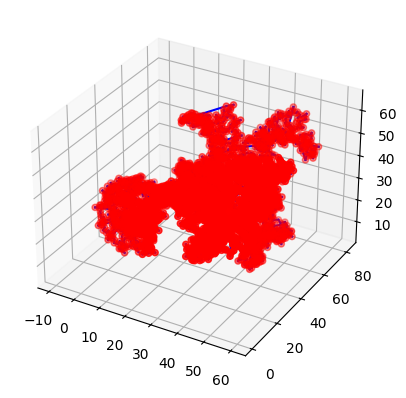

In [6]:
# Function to calculate dihedral angle
def calculate_dihedral(a, b, c, d):
    b1 = a - b
    b2 = c - b
    b3 = d - c
    
    b1 = b1 / np.linalg.norm(b1)
    b2 = b2 / np.linalg.norm(b2)
    b3 = b3 / np.linalg.norm(b3)

    n1 = np.cross(b1, b2)
    n2 = np.cross(b2, b3)

    x = np.dot(n1, n2)
    y = np.dot(np.cross(n1, n2), b2)
    angle = np.arctan2(y, x)
    
    return np.degrees(angle)

# Function to load RNA from PDB file
def load_rna_from_pdb(pdb_file):
    atom_coords = []
    atom_indices = []
    with open(pdb_file, 'r') as file:
        for line in file:
            if line.startswith('ATOM'):
                parts = line.split()
                atom_idx = int(parts[1])  # Atom serial number
                x = float(parts[6])
                y = float(parts[7])
                z = float(parts[8])
                atom_coords.append([x, y, z])
                atom_indices.append(atom_idx)
    return np.array(atom_coords), atom_indices

# Function to visualize the RNA molecule
def visualize_rna(coords, bonds):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='r', marker='o')

    for bond in bonds:
        ax.plot([coords[bond[0], 0], coords[bond[1], 0]],
                [coords[bond[0], 1], coords[bond[1], 1]],
                [coords[bond[0], 2], coords[bond[1], 2]], 'b-')

    plt.show()

# Main function
def main():
    pdb_file = '4gxy.pdb'  # Replace with your PDB file path

    # Load RNA
    atom_coords, atom_indices = load_rna_from_pdb(pdb_file)

    # Define ribose dihedral angles (generalized)
    angles = []
    bonds = []

    for i in range(len(atom_coords) - 3):
        a1 = atom_coords[i]
        a2 = atom_coords[i + 1]
        a3 = atom_coords[i + 2]
        a4 = atom_coords[i + 3]

        angle = calculate_dihedral(a1, a2, a3, a4)
        angles.append((i, i + 1, i + 2, i + 3, angle))
        bonds.append((i, i + 1))  # Add bond connections for visualization

    # Create DataFrame for angles
    angle_df = pd.DataFrame(angles, columns=['Atom1', 'Atom2', 'Atom3', 'Atom4', 'Dihedral Angle (degrees)'])
    print(angle_df)

    # Visualize RNA
    visualize_rna(atom_coords, bonds)

if __name__ == '__main__':
    main()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from Bio.PDB import PDBParser
import subprocess
from dash import Dash, html
from dash_bio import Molecule3dViewer
from jupyter_dash import JupyterDash


In [ ]:
# Initialize parser and load PDB file
parser = PDBParser(QUIET=True)
structure = parser.get_structure("RNA", "4gxy.pdb")

# Extract atom data for Molecule3dViewer
atoms_data = []
bonds_data = []

for model in structure:
    for chain in model:
        for residue in chain:
            for atom in residue:
                atoms_data.append({
                    "name": atom.get_name(),
                    "chain": chain.id,
                    "position": atom.coord.tolist(),
                    "element": atom.element,
                })

# Note: Dash Bio Molecule3dViewer doesn’t require bonds,
# but if you have bond information, you can add it to bonds_data.


In [ ]:
from dash import Dash, html
from dash_bio import Molecule3dViewer
from jupyter_dash import JupyterDash

# Initialize the Dash app
app = JupyterDash(__name__)

# Define layout with Molecule3dViewer
app.layout = html.Div([
    Molecule3dViewer(
        id='molecule-viewer',
        modelData={
            "atoms": atoms_data,
            "bonds": bonds_data
        }
    )
])

# Run app inline in Jupyter Notebook
app.run_server(mode="inline")


In [ ]:
import numpy as np
from Bio.PDB import PDBParser

def dihedral(p1, p2, p3, p4):
    """Calculate dihedral angle from four 3D points (p1, p2, p3, p4)."""
    b0 = -1.0 * (p2 - p1)
    b1 = p3 - p2
    b2 = p4 - p3

    b1 /= np.linalg.norm(b1)
    v = b0 - np.dot(b0, b1) * b1
    w = b2 - np.dot(b2, b1) * b1
    x = np.dot(v, w)
    y = np.dot(np.cross(b1, v), w)
    return np.degrees(np.arctan2(y, x))

# Load PDB structure
parser = PDBParser(QUIET=True)
structure = parser.get_structure("RNA", "4gxy.pdb")

# Define a list to store dihedral angles with corresponding details
dihedral_info = []

# Iterate through each residue to calculate dihedral angles
for model in structure:
    for chain in model:
        for residue in chain:
            try:
                # Example for ν0 (O3'-C3'-C2'-C1')
                O3_prime = residue['O3\''].coord
                C3_prime = residue['C3\''].coord
                C2_prime = residue['C2\''].coord
                C1_prime = residue['C1\''].coord
                nu0 = dihedral(O3_prime, C3_prime, C2_prime, C1_prime)
                dihedral_info.append({
                    "residue": residue.id[1],
                    "angle_name": "ν0",
                    "atoms": ["O3'", "C3'", "C2'", "C1'"],
                    "angle": nu0
                })

                # Repeat for ν1, ν2, etc. with appropriate atoms
                # ν1 example: (C3'-C2'-C1'-O4')
                O4_prime = residue['O4\''].coord
                nu1 = dihedral(C3_prime, C2_prime, C1_prime, O4_prime)
                dihedral_info.append({
                    "residue": residue.id[1],
                    "angle_name": "ν1",
                    "atoms": ["C3'", "C2'", "C1'", "O4'"],
                    "angle": nu1
                })

                # Add further angles as needed

            except KeyError:
                # Skip residues missing any required atom
                continue

# Display the results in a readable format
for info in dihedral_info:
    print(f"Residue {info['residue']} - {info['angle_name']}: "
          f"Atoms {info['atoms']} - Angle = {info['angle']:.2f}°")


In [ ]:
import pandas as pd
import numpy as np
from Bio.PDB import PDBParser

# Function to calculate dihedral angle
def dihedral(p1, p2, p3, p4):
    b0 = -1.0 * (p2 - p1)
    b1 = p3 - p2
    b2 = p4 - p3
    b1 /= np.linalg.norm(b1)
    v = b0 - np.dot(b0, b1) * b1
    w = b2 - np.dot(b2, b1) * b1
    x = np.dot(v, w)
    y = np.dot(np.cross(b1, v), w)
    return np.degrees(np.arctan2(y, x))

# Parse PDB structure
parser = PDBParser(QUIET=True)
structure = parser.get_structure("RNA", "4gxy.pdb")

# Lists to store dihedral angles and calculated values
data = []

# Calculate dihedral angles and tan(P), v(max)
for model in structure:
    for chain in model:
        for residue in chain:
            try:
                # Calculate ν angles
                O3_prime = residue['O3\''].coord
                C3_prime = residue['C3\''].coord
                C2_prime = residue['C2\''].coord
                C1_prime = residue['C1\''].coord
                O4_prime = residue['O4\''].coord

                nu0 = dihedral(O3_prime, C3_prime, C2_prime, C1_prime)
                nu1 = dihedral(C3_prime, C2_prime, C1_prime, O4_prime)

                # Add further angles as needed for ν2, ν3, ν4...

                # Example tan(P) and v(max) calculation
                tan_P = np.tan(np.radians(nu0 + nu1))  # Simplified, adjust if needed
                v_max = max(abs(nu0), abs(nu1))  # Adjust as needed for all ν angles

                # Store in data list
                data.append([residue.id[1], nu0, nu1, tan_P, v_max])

            except KeyError:
                # Skip residues missing any required atom
                continue

# Convert to DataFrame for display
df = pd.DataFrame(data, columns=["Residue", "ν0", "ν1", "tan(P)", "v(max)"])
print(df)


In [ ]:
import numpy as np
import pandas as pd
from Bio.PDB import PDBParser

# Function to calculate pseudorotation phase angle (P) and determine conformation
def calculate_pseudorotation_and_conformation(nu_angles):
    P = np.degrees(np.arctan2(nu_angles[4] + nu_angles[1] - nu_angles[3] - nu_angles[0], 2 * nu_angles[2]))
    conformation = "C3'-endo" if abs(P - 18) < abs(P - 162) else "C2'-endo"
    return P, conformation

# Example data structure, replace with actual dihedral angle data
# dihedral_data is a list of dictionaries with residue id and ν angles (ν0 to ν4)
dihedral_data = [
    {"residue": 1, "nu_angles": [12.34, -45.67, 30.45, 22.89, -15.32]},
    # Add more residues as needed
]

# List to store results
results = []

# Calculate P and conformation for each residue
for entry in dihedral_data:
    P, conformation = calculate_pseudorotation_and_conformation(entry["nu_angles"])
    results.append({"Residue": entry["residue"], "Pseudorotation Angle (P)": P, "Conformation": conformation})

# Display results in a readable table
df = pd.DataFrame(results)
print(df)
